## **Imports**

In [27]:
import os
import time
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import onnxruntime as ort
from nemo.collections.asr.models import EncDecCTCModel

"""Setting provider and device dynamically"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
provider = "CUDAExecutionProvider" if torch.cuda.is_available() else "CPUExecutionProvider"

## **Input Pre-Processing**

In [ ]:
def preprocess_audio_for_onnx(file_path, target_sr=16000, n_mels=80):
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample
    if sample_rate != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
        waveform = resampler(waveform)
    
    # Normalize
    waveform = waveform / waveform.abs().max()
    
    # Extracting log-mel spectrogram
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_mels=n_mels,
        n_fft=400,
        win_length=400,
        hop_length=160
    )
    mel_spec = mel_spec_transform(waveform)  # (1, 80, time)
    log_mel_spec = torch.log(mel_spec + 1e-9)  # adding epsilon to avoid log(0)
    
    # Input for ONNX
    audio_signal = log_mel_spec.numpy()  # (1, 80, time)
    length = np.array([audio_signal.shape[2]], dtype=np.int64)  # (1,)
    
    return audio_signal, length, waveform

In [29]:
audio_signal, length, waveform = preprocess_audio_for_onnx("test/test1.wav")

audio_signal = audio_signal.astype(np.float32)  # float32
length = length.astype(np.int64)               # int64

onnx_input = {
    "audio_signal": audio_signal,  # shape: (1, 80, time)
    "length": length               # shape: (1,)
}

print(f"audio_signal shape: {audio_signal.shape}, dtype: {audio_signal.dtype}")
print(f"length shape: {length.shape}, dtype: {length.dtype}")


audio_signal shape: (1, 80, 997), dtype: float32
length shape: (1,), dtype: int64


## **NeMo & ONNX ASR Model**

In [30]:
# === Original NeMo Model ===
asr_model = EncDecCTCModel.restore_from("model/stt_hi_conformer_ctc_medium.nemo").eval().to(device)

# Converting to ONNX 
asr_model.export(
    output="model/nemo_conformer_exported.onnx",
    onnx_opset_version=13
)

# === ONNX Model Path ===
onnx_model_path = "model/nemo_conformer_exported.onnx"

[NeMo I 2025-05-24 22:19:37 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-05-24 22:19:37 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /code/03_manifest/ulca-train-v3.json
    sample_rate: 16000
    batch_size: 64
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    
[NeMo W 2025-05-24 22:19:37 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /code/manifest/ulca-eval.json
    sample_rate: 16000
    batch_size: 4
    shuffle: false
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    
[NeMo W 2025-05-24 22:19:37 n

[NeMo I 2025-05-24 22:19:37 nemo_logging:393] PADDING: 0
[NeMo I 2025-05-24 22:19:38 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from d:\IIT BBS\Job Resources\mvaakAI\asr_app\model\stt_hi_conformer_ctc_medium.nemo.
[NeMo I 2025-05-24 22:19:43 nemo_logging:393] Successfully exported EncDecCTCModelBPE to model/nemo_conformer_exported.onnx


## **Search Space for Graph Optimization**

In [31]:
# === Search Space ===
search_space = [
    {"opt_level": ort.GraphOptimizationLevel.ORT_DISABLE_ALL, "intra_threads": 1},
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_BASIC, "intra_threads": 1},
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED, "intra_threads": 1},
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_ALL, "intra_threads": 1},
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_ALL, "intra_threads": 2},
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_ALL, "intra_threads": 4},
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_ALL, "intra_threads": 8},  # NEW
    {"opt_level": ort.GraphOptimizationLevel.ORT_ENABLE_ALL, "intra_threads": 16}, # NEW
]

results = []

## **ONNX Benchmarks**

In [32]:
# === Benchmark ONNX configs ===
for i, cfg in enumerate(search_space):
    sess_options = ort.SessionOptions()
    sess_options.graph_optimization_level = cfg["opt_level"]
    sess_options.intra_op_num_threads = cfg["intra_threads"]
    
    session = ort.InferenceSession(onnx_model_path, sess_options, providers=["CPUExecutionProvider"])

    # Warm-up
    _ = session.run(None, onnx_input)

    # Time
    start = time.time()
    for _ in range(5):
        preds = session.run(None, onnx_input)
    end = time.time()
    
    avg_time = (end - start) / 5
    log_probs = preds[0][0]  # batch=1

    # Greedy decode
    pred_ids = np.argmax(log_probs, axis=-1)
    text = asr_model.decoding.ctc_decoder_predictions_tensor(torch.tensor(pred_ids).unsqueeze(0))[0]

    results.append({
        "config": f"{cfg['opt_level'].name}-T{cfg['intra_threads']}",
        "inference_time": avg_time,
        "prediction": text
    })

### **NeMo Benchmark**

In [33]:
# === Benchmark NeMo PyTorch ===
input_signal, input_length = waveform, torch.tensor([waveform.shape[1]]).to(device)

with torch.no_grad():
    start = time.time()
    for _ in range(5):
        logits = asr_model(input_signal=input_signal.to(device), input_signal_length=input_length)[0]
    end = time.time()

    avg_time = (end - start) / 5
    pred_ids = torch.argmax(logits, dim=-1)
    text = asr_model.decoding.ctc_decoder_predictions_tensor(pred_ids)[0]


    results.append({
        "config": "NeMo_PyTorch",
        "inference_time": avg_time,
        "prediction": text
    })

## **Inference Times**

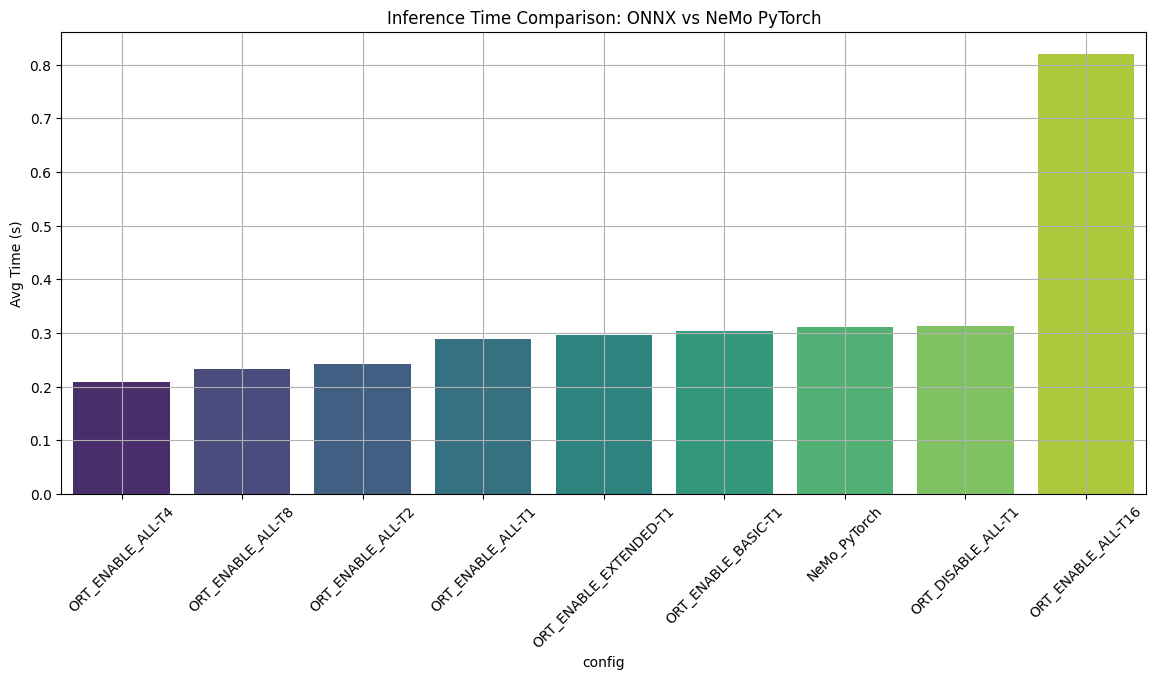

In [34]:
# === DataFrame ===
df = pd.DataFrame(results).sort_values("inference_time")

# === Plots - Inference Times ===
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="config", y="inference_time", palette="viridis")
plt.title("Inference Time Comparison: ONNX vs NeMo PyTorch")
plt.ylabel("Avg Time (s)")
plt.xticks(rotation=45)
plt.grid(True)

## **Best Optimized Model**

In [35]:
# === Best Config
best_config = df.iloc[0]
print("\nBest Optimized Config:")
print(best_config)


Best Optimized Config:
config                                            ORT_ENABLE_ALL-T4
inference_time                                             0.207768
prediction        Hypothesis(score=-1.0, y_sequence=tensor([128,...
Name: 5, dtype: object


In [ ]:
best_onnx = df[df["config"] != "NeMo_PyTorch"].sort_values("inference_time").iloc[0]

best_onnx_path = "model/best_optimized_onnx_model.onnx"
os.rename("model/nemo_conformer_exported.onnx", best_onnx_path)

print(f"Best ONNX model saved as: {best_onnx_path}")


 Best ONNX model saved to model/nemo_conformer_optimized_ORT_ENABLE_ALL_T4.onnx
